# Cedric - Fun Stuff With Lastfm (part 1)

### Overview

It looks like this:

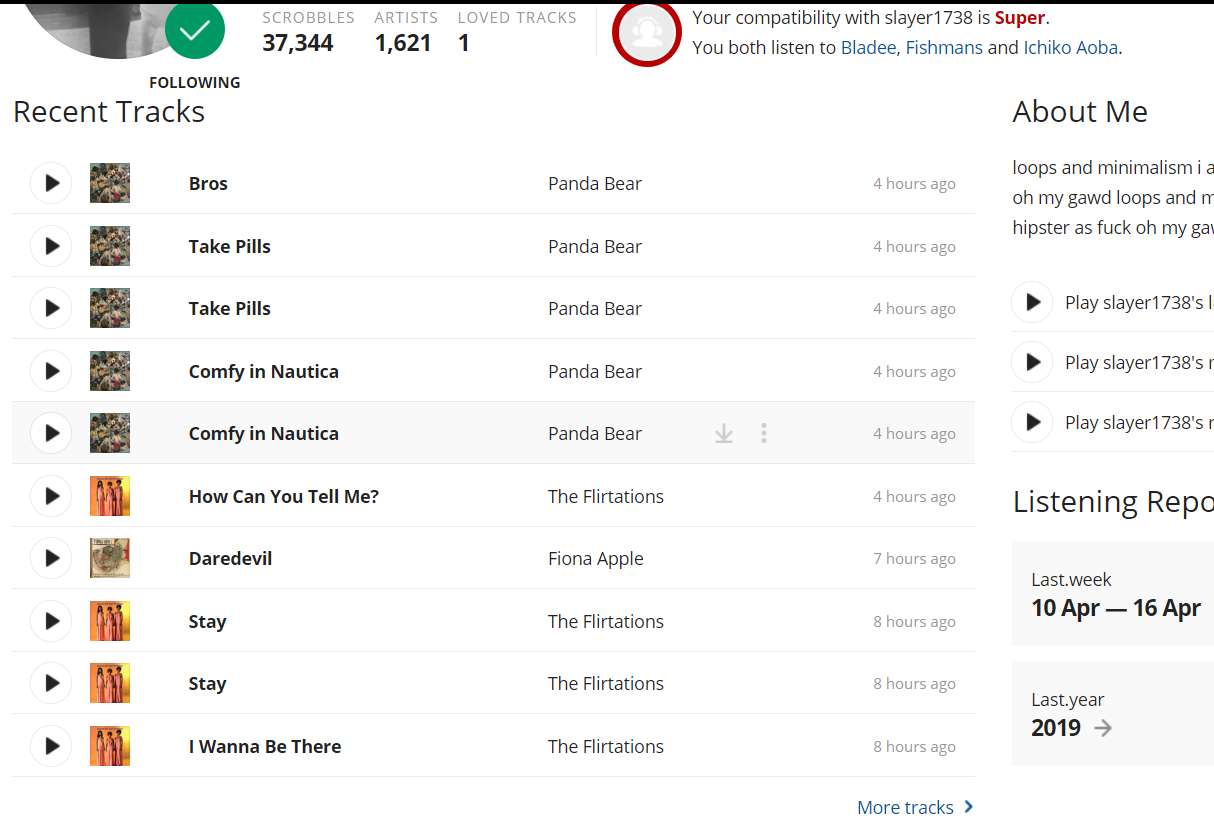

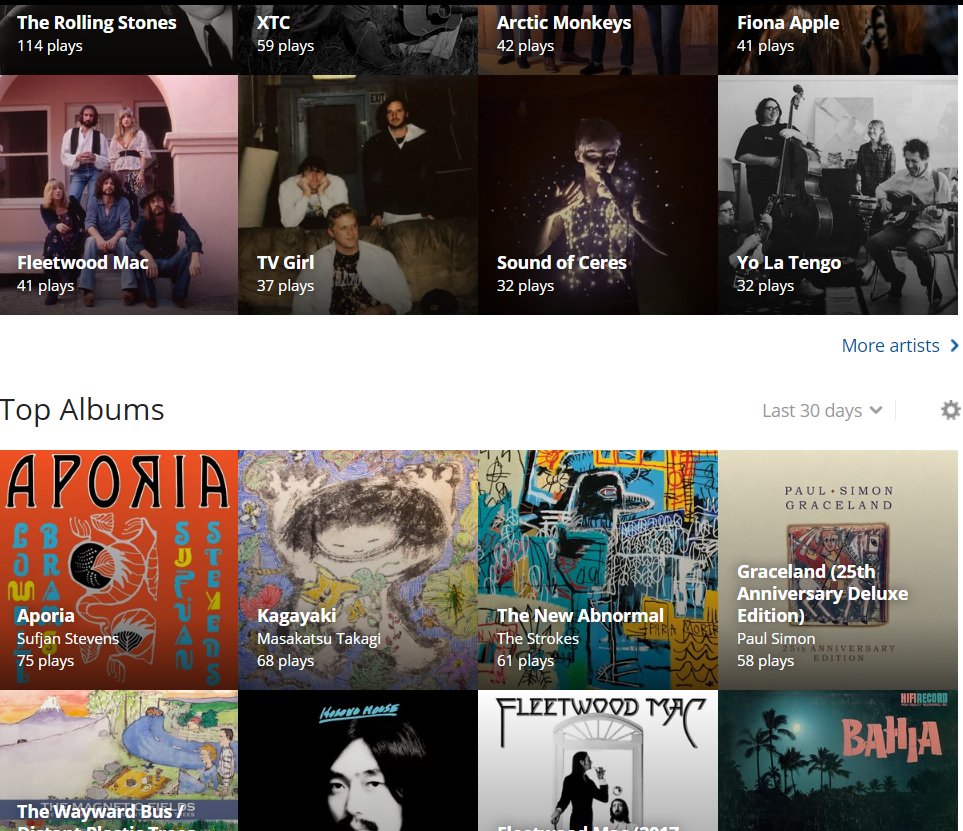

## Part 1: Some intro to last.fm web scraping + get my scrobbling data

In [64]:
import requests, json, time, pandas as pd

In [31]:
#Define API key
key = '59e37a60fe05bd172cb0554dac238fa0'

#Add username:
username = 'lvtwoodpecker'

# Spread out consecutive API requests with pauses
pause_duration = 0.15

Next up, try to get the top tracks for lvtwoodpecker. This is using the method to user.gettoptracks to display results.

In particular, I'm just looking at the first page for practice

In [50]:
#First, define a few things on the url to specify what you want to retrieve and how
url = 'https://ws.audioscrobbler.com/2.0/?method=user.get{}&user={}&api_key={}&limit={}&extended={}&page={}&format={}'

parse_format = 'json'
limit = 200 #how much you can retrieve per call
extended = 1 #api lets you retrieve extended data for each track, 0=no, 1=yes
page = 1 #page of results to start at

In [51]:
#Our search method is toptracks
method = 'toptracks'

top_artist_url = url.format(method, username, key, limit, extended, page, parse_format)

response = requests.get(top_artist_url).json()

r.status_code #if it returns 200 then it's functioning fine

200

In [55]:
#Okay so that should work, now move on! Appending stuff!

#Create blank arrays to append the results into
artist_names = []
track_names = []
play_counts = []

#For element inside the method top track, and the key value 'track', append the necessary characteristics
for item in response[method]['track']:
    artist_names.append(item['artist']['name'])
    track_names.append(item['name'])
    play_counts.append(item['playcount'])


In [56]:
#Make a data frame out of it

top_tracks = pd.DataFrame()
top_tracks['artist'] = artist_names
top_tracks['track'] = track_names
top_tracks['play_count'] = play_counts

top_tracks.head()

,artist,track,play_count
0,Pavement,Gold Soundz,58
1,Van Morrison,Ballerina,58
2,Curling,Radio King,56
3,Built to Spill,Carry the Zero,53
4,Brian Eno,On Some Faraway Beach,49


In [154]:
#Save the above to a csv file
top_tracks.to_csv('B:\Music Datasets\API Mined\lastfm_toptracks.csv', index =None, encoding="utf-8")

## Next up! Get all da scrobbles! 40,000 + of them (I started scrobbling seriously in late 2018)

Use the method get.recenttracks to get everything "recent" from day 1 to now! Data updated on 4/15/2020 but there are some pages with errors so I ignored some of them :(

In [140]:
def get_scrobbles(method='recenttracks', username=username, key=key, limit=200, extended=0, page=1, pages=0):
    '''
    method: api method
    username/key: api credentials
    limit: api lets you retrieve up to 200 records per call
    extended: api lets you retrieve extended data for each track, 0=no, 1=yes
    page: page of results to start retrieving at
    pages: how many pages of results to retrieve. if 0, get as many as api can return.
    
    return responses: array of responses
    '''
    
    # initialize url and response array to contain the info
    url = 'https://ws.audioscrobbler.com/2.0/?method=user.get{}&user={}&api_key={}&limit={}&extended={}&page={}&format=json'
    responses = []
    
    #get the total number of pages there are in the listening history
    request_url = url.format(method, username, key, limit, extended, page)
    response = requests.get(request_url).json()
    total_pages = int(response[method]['@attr']['totalPages'])
    
    if pages > 0: #if specified otherwise
        total_pages = min([total_pages, pages])
    
    print('I\'m about to retrieve {} pages beep bop'.format(total_pages))
    
    #request each page of data, one at a time, with pauses to not overload the server
    for page_to_append in range(1, total_pages + 1):
        
        #make this to show progress update every 10 pages
        if page % 10 == 0:
            print(page, end='   ')
            
        #separate time between each call
        time.sleep(pause_duration)
        
        #append the page result into the responses list
        request_url = url.format(method, username, key, limit, extended, page_to_append)
        responses.append(requests.get(request_url))
        
    return responses

In [152]:
scrobbles = get_scrobbles()
scrobbles

I'm about to retrieve 219 pages beep bop


[<Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [500]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [500]>,
 <Response [500]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [404]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [

#### Oh no! 7 of those 219 pages returned an error -- I still have 41,000+ scrobbles though so it's alright. The API is really funky.

Next up, get those responses into a dataframe

In [125]:
def append_scrobbles(responses):
    '''
    responses: array of api responses from get_scrobbles
    
    return scrobble_df: dataframe of scrobbles
    '''
    #initialize the arrays we need to append info into
    method = 'recenttracks'
    artist_names = []
    album_names = []
    album_mbids = []
    track_names = []
    timestamps = []
    #artist_mbids = []. Only need these if I need to look them up on musicbrainz later for more metadata
    #track_mbids = []
    
    # parse the fields out of each scrobble in each page of scrobbles
    for response in responses:
        
        #ignore unsuccessful responses
        if response.status_code == 200:
            scrobbles = response.json()
            
            for scrobble in scrobbles[method]['track']:
                # only retain completed scrobbles (aka, with timestamp and not 'now playing')
                if 'date' in scrobble.keys():
                    artist_names.append(scrobble['artist']['#text'])
                    album_names.append(scrobble['album']['#text'])
                    album_mbids.append(scrobble['album']['mbid'])
                    track_names.append(scrobble['name'])
                    timestamps.append(scrobble['date']['uts'])
 
    # add all of them to dataframe
    scrobble_df = pd.DataFrame()
    scrobble_df['artist'] = artist_names
    scrobble_df['album'] = album_names
    scrobble_df['album_mbid'] = album_mbids
    scrobble_df['track'] = track_names
    scrobble_df['timestamp'] = timestamps
    #convert that timestamp to date_time
    scrobble_df['datetime'] = pd.to_datetime(scrobble_df['timestamp'].astype(int), unit='s')
    
    return scrobble_df

In [173]:
df = append_scrobbles(scrobbles)
df.head(10)

,artist,album,album_mbid,track,timestamp,datetime
0,Spiritualized,Ladies & Gentlemen We Are Floating In Space,,Ladies and Gentlemen We Are Floating in Space,1587012565,2020-04-16 04:49:25
1,Yo La Tengo,Summer Sun,ae471e32-e6f9-445e-89f4-2f1e138c648c,Season of the Shark,1587012290,2020-04-16 04:44:50
2,Aphex Twin,Selected Ambient Works 85-92,0c8b4425-795e-4772-8cbf-e3f9694110cc,Ageispolis,1587011966,2020-04-16 04:39:26
3,Dinosaur Jr.,Without a Sound,24694020-67b0-466a-bb6b-d43a4c308312,Feel the Pain,1587011706,2020-04-16 04:35:06
4,Stella Donnelly,Beware of the Dogs,13bcbdf0-6852-4218-bc46-9d7f12d722e6,Season’s Greetings,1587011536,2020-04-16 04:32:16
5,The Strokes,Room on Fire,0f3cb2a7-8f63-4fd5-a331-39844400b9e4,12:51,1587011380,2020-04-16 04:29:40
6,Yo La Tengo,Summer Sun,ae471e32-e6f9-445e-89f4-2f1e138c648c,Nothing But You and Me,1587011065,2020-04-16 04:24:25
7,Yo La Tengo,I Can Hear the Heart Beating as One,3a5178c8-ce0b-3971-a5f5-a3331972df3f,We're an American Band,1587010679,2020-04-16 04:17:59
8,Car Seat Headrest,Twin Fantasy,5637ea6c-8089-4923-ba98-72a3b724f3f3,Bodys,1587009780,2020-04-16 04:03:00
9,of Montreal,"Hissing Fauna, Are You the Destroyer?",12762a06-5457-4afd-a3b4-a5160a30dccc,Heimdalsgate Like A Promethean Curse,1587009581,2020-04-16 03:59:41


In [159]:
df.to_csv('B:\Music Datasets\API Mined\lastfm_scrobbles.csv', index=None, encoding='utf-8')

**Maybe I can try to get top artists and albums as well...**

### Top Albums

In [162]:
#Get top albums

method = 'topalbums'
request_url = url.format(method, username, key, limit, extended, page, parse_format)
artist_names = []
album_names = []
play_counts = []
response = requests.get(request_url).json()
for item in response[method]['album']:
    artist_names.append(item['artist']['name'])
    album_names.append(item['name'])
    play_counts.append(item['playcount'])

top_albums = pd.DataFrame()
top_albums['artist'] = artist_names
top_albums['album'] = album_names
top_albums['play_count'] = play_counts
top_albums.to_csv('B:\Music Datasets\API Mined\lastfm_top_albums.csv', index=None, encoding='utf-8')
top_albums.head()

,artist,album,play_count
0,Curling,Definitely Band,381
1,Brian Eno,Here Come The Warm Jets,305
2,Radiohead,In Rainbows,283
3,Yo La Tengo,I Can Hear the Heart Beating as One,272
4,Pavement,"Crooked Rain, Crooked Rain",266


### Top Artists

In [163]:
method = 'topartists'
request_url = url.format(method, username, key, limit, extended, page, parse_format)
artist_names = []
play_counts = []
response = requests.get(request_url).json()
for item in response[method]['artist']:
    artist_names.append(item['name'])
    play_counts.append(item['playcount'])

top_artists = pd.DataFrame()
top_artists['artist'] = artist_names
top_artists['play_count'] = play_counts
top_artists.to_csv('B:\Music Datasets\API Mined\lastfm_top_artists.csv', index=None, encoding='utf-8')
top_artists.head()

,artist,play_count
0,Yo La Tengo,1102
1,Radiohead,1080
2,David Bowie,1027
3,Sufjan Stevens,722
4,The Beatles,663


Based off of the following works:

ytneu: https://github.com/ytneu/music-analysis-medium

gboeing: https://github.com/gboeing/data-visualization/blob/master/lastfm-listening-history

Dataquest: https://www.dataquest.io/blog/last-fm-api-python/